<h1 align="center">Self Driving Car</h1>

In this project, I'm trying to emulate the rotation of the steering wheel of a running car, essentially - an autopilot system. The architecture of the Neural Network used comes from [this](https://arxiv.org/pdf/1604.07316.pdf) paper from NVidia titled **"End to End Learning for self Driving cars"**.

The speciality of this approach is precisely described in the title. By "End to End" they really mean that no manual feature extraction has gone into building this autonomous self driving system. The Neural Network receives raw image frames as inputs and outputs the steering angle of the car.

The metric used to judge the performance of the model is RMSE. In this notebook, I'll try to implement the model architecture provided by NVdia in their paper using Tensorflow. I'm also taking some help from the github repository by [SullyChen](https://github.com/SullyChen/Autopilot-TensorFlow).

Let's start by importing the libraries we need.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import scipy
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
from tensorflow.core.protobuf import saver_pb2
from scipy import pi
from itertools import islice
import scipy
import scipy.misc
import random
from PIL import Image
from imageio import imread
import scipy.misc
import model
import cv2
from subprocess import call
import math
import pickle

# Model Architecture

Following is the model we will build. This architecture was designed by the researchers from Nvidia. The link to the original research paper is given above.

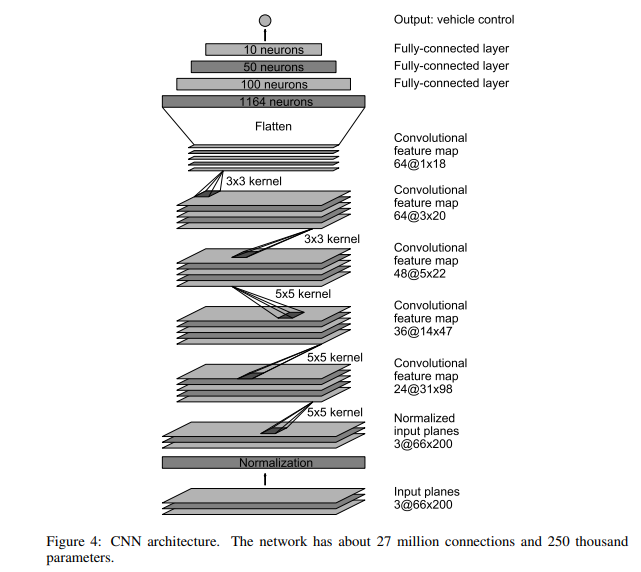

In [12]:
from IPython.display import Image
Image('network architecture.png')

# A look at the training and test data

The training data consists of video footage of a car being driven on a road. The video is then broken down into its constituent frames such that all consecutive frames of the video are numbered starting from 1. Follwing plot shows 10 random images taken from this training data.

In [2]:
imread('driving_dataset/2.jpg').shape

(256, 455, 3)

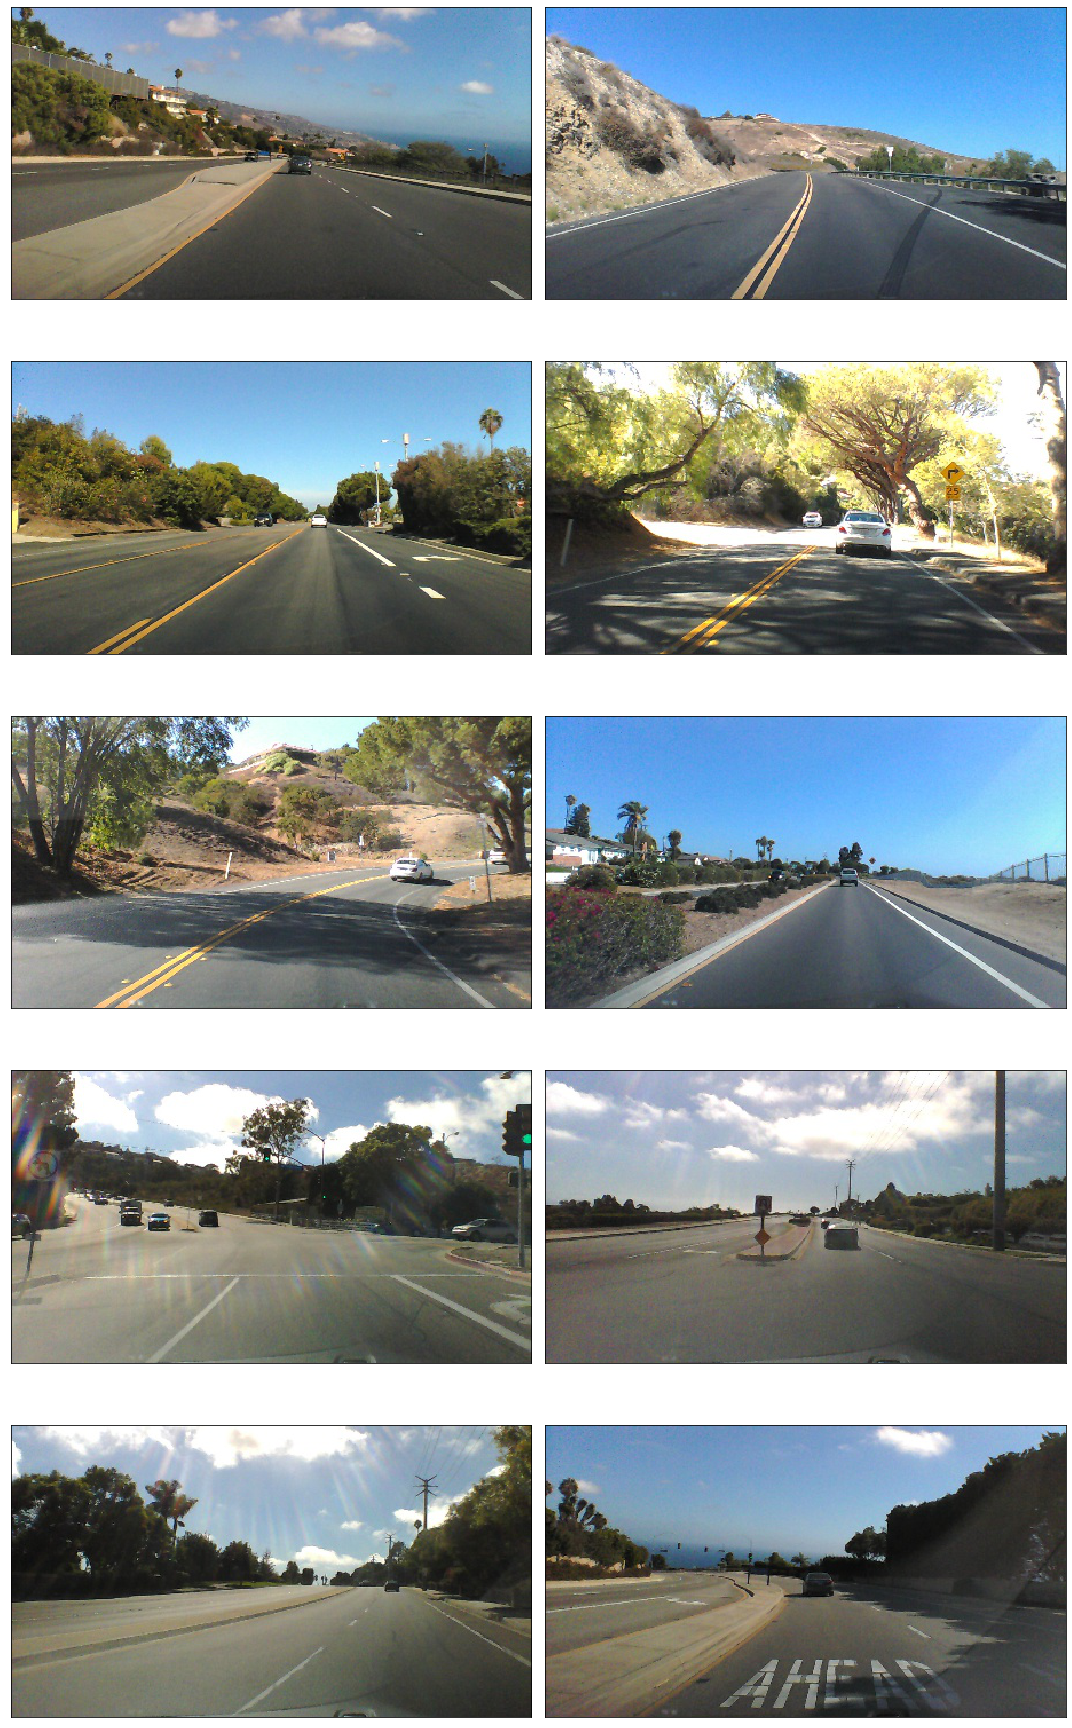

In [33]:
plt.figure(figsize=(15,25))
for i in range(1, 11):
    plt.subplot(5,2, i)
    plt.imshow(imread(train_xs[np.random.choice(len(train_xs))]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

I'll use a GPU for training the neural network model. Let's confirm that the GPU is available and tensorflow can use it.

In [3]:
tf.test.is_gpu_available()

True

# Utility Functions

In this section, let's define some functions for loading and processing the raw images stored on the disk.


The function `get_datasets` takes a ratio `r` as input. Splits the total data into train and test in the ratio `r:(1-r)`.

the research paper by Nvidia (referenced above) uses the inverse of the turning radius, but steering wheel angle is proportional to the inverse of turning radius. Therefore the steering wheel angle in radians is used as the output in our models.

In [2]:
#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0


def get_datasets(r):
    xs = []
    ys = []

    #read data.txt
    with open("driving_dataset/data.txt") as f:
        for line in f:
            xs.append("driving_dataset/" + line.split()[0])
            ys.append(float(line.split()[1]) * scipy.pi / 180)

    #get number of images
    num_images = len(xs)


    train_xs = xs[:int(len(xs) * r)]
    train_ys = ys[:int(len(xs) * r)]

    val_xs = xs[-int(len(xs) * (1-r)):]
    val_ys = ys[-int(len(xs) * (1-r)):]
    
    return train_xs, train_ys, val_xs, val_ys, num_images

Functions to create weight, bias variables in Tensorflow

In [3]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

Functions to load train and validation batches

In [4]:
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)        
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

# Model 1

This model uses ArcTan as the output activation function.

Let's split the data in train and test using the function we just defined above.

In [7]:
train_xs, train_ys, val_xs, val_ys, num_images = get_datasets(r=0.8)

num_train_images = len(train_xs)
num_val_images = len(val_xs)

The training data X contains the name of the files on disk which will be used for training. The target labels are steering angles.

In [13]:
len(train_xs)

36324

In [6]:
train_xs[:5]

['driving_dataset/0.jpg',
 'driving_dataset/1.jpg',
 'driving_dataset/2.jpg',
 'driving_dataset/3.jpg',
 'driving_dataset/4.jpg']

In [7]:
train_ys[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

# Define the model

In [8]:
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output

W1021 11:41:53.177953 139961331885888 deprecation.py:506] From <ipython-input-8-ea313358ae9f>:44: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Train the model

In [10]:
LOGDIR = './model_1'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
#sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.8})
    if i % 200 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model_1.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Epoch: 0, Step: 0, Loss: 7.91794
Epoch: 0, Step: 200, Loss: 5.55143
Epoch: 0, Step: 400, Loss: 4.67302
Model saved in file: ./model_1/model_1.ckpt
Epoch: 1, Step: 100, Loss: 4.47559
Epoch: 1, Step: 300, Loss: 3.94405
Epoch: 1, Step: 500, Loss: 3.61593
Model saved in file: ./model_1/model_1.ckpt
Epoch: 2, Step: 200, Loss: 4.18151
Epoch: 2, Step: 400, Loss: 4.60693
Epoch: 2, Step: 600, Loss: 2.93086
Model saved in file: ./model_1/model_1.ckpt
Epoch: 3, Step: 300, Loss: 2.77895
Epoch: 3, Step: 500, Loss: 2.44142
Epoch: 3, Step: 700, Loss: 2.25487
Model saved in file: ./model_1/model_1.ckpt
Epoch: 4, Step: 400, Loss: 2.20451
Epoch: 4, Step: 600, Loss: 2.04642
Epoch: 4, Step: 800, Loss: 1.93309
Model saved in file: ./model_1/model_1.ckpt
Epoch: 5, Step: 500, Loss: 1.92216
Epoch: 5, Step: 700, Loss: 1.73565
Epoch: 5, Step: 900, Loss: 1.724
Model saved in file: ./model_1/model_1.ckpt
Epoch: 6, Step: 600, Loss: 1.97193
Epoch: 6, Step: 800, Loss: 1.79061
Epoch: 6, Step: 1000, Loss: 1.54522
Mode

# Testing the model

The following GIF shows the performance of the trained model on test data. For each frame, the trained model calculates the output (angle in degrees), which is then used to rotate the steering wheel image, which gives us a better visual way to see for ourselves how the model is performing. As you can see below, the model performs quite well.

NOTE: If you can't see the GIF, it's probably because it hasn't finished loading yet. It's ~70 MB in size.

![](model_1c.gif)

Here's the code used to create the above visualization. I ran it separately in the terminal.

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

saver.restore(sess, "tanmay/model2/model_2.ckpt")
img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = int(math.ceil(num_images*0.8))
print("Starting frameofvideo:" +str(i))

predicted_angles = []
actual_angles = []

while(cv2.waitKey(10) != ord('q')) and i < num_images:
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    predicted_angles.append(degrees)
    actual_angles.append(ys[i]*180/scipy.pi)
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1
        
pickle.dump(predicted_angles, open('predicted_angles2.lst', 'wb'))
pickle.dump(actual_angles, open('actual_angles2.lst', 'wb'))
    
    
cv2.destroyAllWindows()

# RMSE

The other standard method to gauge the performance of our model is the Root Mean Squared Error.

In [5]:
def rmse(predictions, targets):
    return np.sqrt(((np.array(predictions) - np.array(targets)) ** 2).mean())

Loading the actual and predicted angles I stored on disk during the testing.

In [17]:
actual_angles = pickle.load(open('actual_angles.lst', 'rb'), encoding='latin1')
predicted_angles = pickle.load(open('predicted_angles.lst', 'rb'), encoding='latin1')

This model generates an RMSE of 22.94, and a mean absolute deviation of 11.32. Considering the complexity of the task at hand, i.e. predicting the steering angle from the only the image of the curvature of the road, this is pretty amazing.  

In [13]:
from sklearn.metrics import mean_absolute_error
RMSE = rmse(predicted_angles, actual_angles)
MAE = mean_absolute_error(actual_angles, predicted_angles)

In [27]:
print('*' * 40, 'MODEL PERFORMANCE', '*'*40)
print('Root Mean Squared Error:', RMSE)
print('Mean Absolute Error:', MAE)
print('*' * 99)

**************************************** MODEL PERFORMANCE ****************************************
Root Mean Squared Error: 22.94875340720251
Mean Absolute Error: 11.324148054708385
***************************************************************************************************


# Model 2:

Model 2 differs from model 1 as following-
    
    1. Train/Test split is 70-30
    2. For ADAM optimizer use 1e-3
    3. Dropout -> Keep prob 0.5
    4. Final Layer -> Use linear instead of Atan
    
Let's obtain the train and test datasets.

In [6]:
train_xs, train_ys, val_xs, val_ys, num_images = get_datasets(r=0.7)

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [7]:
len(train_xs), len(val_xs)

(31784, 13621)

In [8]:
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

# y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output
y = tf.multiply(tf.matmul(h_fc4_drop, W_fc5) + b_fc5, 2)

W1021 15:27:46.784323 140074584672064 deprecation.py:506] From <ipython-input-8-a83936947f9a>:44: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Train the model

In [9]:
LOGDIR = './model_2'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 20
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.5})
    if i % 200 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model_2.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Epoch: 0, Step: 0, Loss: 6.57088
Epoch: 0, Step: 200, Loss: 2.68802
Epoch: 0, Step: 400, Loss: 1.55608
Model saved in file: ./model_2/model_2.ckpt
Epoch: 1, Step: 100, Loss: 1.37905
Epoch: 1, Step: 300, Loss: 1.18447
Epoch: 1, Step: 500, Loss: 0.58406
Model saved in file: ./model_2/model_2.ckpt
Epoch: 2, Step: 200, Loss: 0.605801
Epoch: 2, Step: 400, Loss: 0.643736
Epoch: 2, Step: 600, Loss: 0.442166
Model saved in file: ./model_2/model_2.ckpt
Epoch: 3, Step: 300, Loss: 0.263257
Epoch: 3, Step: 500, Loss: 0.180395
Epoch: 3, Step: 700, Loss: 0.143843
Model saved in file: ./model_2/model_2.ckpt
Epoch: 4, Step: 400, Loss: 0.169291
Epoch: 4, Step: 600, Loss: 0.388273
Epoch: 4, Step: 800, Loss: 0.747309
Model saved in file: ./model_2/model_2.ckpt
Epoch: 5, Step: 500, Loss: 0.423563
Epoch: 5, Step: 700, Loss: 1.0438
Epoch: 5, Step: 900, Loss: 0.342363
Model saved in file: ./model_2/model_2.ckpt
Epoch: 6, Step: 600, Loss: 0.594522
Epoch: 6, Step: 800, Loss: 0.359868
Epoch: 6, Step: 1000, Loss

Loading the actual and predicted angles for model 2 which I'd saved onto the disk.

In [16]:
actual_angles = pickle.load(open('actual_angles2.lst', 'rb'), encoding='latin1')
predicted_angles = pickle.load(open('predicted_angles2.lst', 'rb'), encoding='latin1')

Calculate the two metrics

In [17]:
RMSE = rmse(predicted_angles, actual_angles)
MAE = mean_absolute_error(actual_angles, predicted_angles)

In [19]:
print('*' * 40, 'MODEL 2 PERFORMANCE', '*'*40)
print('Root Mean Squared Error:', RMSE)
print('Mean Absolute Error:', MAE)
print('*' * 99)

**************************************** MODEL 2 PERFORMANCE ****************************************
Root Mean Squared Error: 25.025782270772428
Mean Absolute Error: 12.562952420848493
***************************************************************************************************


# Concluding Remarks

* I tried out the neural network architecture of a self driving car given by NVidia in their research paper.
* This end to end model takes in raw image frames as input and learns to predict the steering angle of the car with satisfactory accuracy
* I experimented a bit with the size of the train/test sets, dropout rates and activation functions and tested how the model's performance varies with change in the hyperparameters.